In [17]:
import torch
import numpy as np

In [18]:
grid_size_x = 34
grid_size_y = 34
dx = 1 / (grid_size_x)
dy = 1 / (grid_size_y)
dx2 = dx ** 2
dy2 = dy ** 2

# generate Matrix A which is the discretized Laplacian in 2D
A = np.zeros((grid_size_x * grid_size_y, grid_size_x * grid_size_y))
for i in range(grid_size_x):
    for j in range(grid_size_y):
        row = i * grid_size_y + j
        A[row, row] = -2 * (1 / dx2 + 1 / dy2)
        if i > 0:
            A[row, row - grid_size_y] = 1 / dx2
        if i < grid_size_x - 1:
            A[row, row + grid_size_y] = 1 / dx2
        if j > 0:
            A[row, row - 1] = 1 / dy2
        if j < grid_size_y - 1:
            A[row, row + 1] = 1 / dy2

A_inverse = np.linalg.inv(A)

In [19]:
model_eigenvectors = torch.jit.load("../models/eigenvectors_cosine_similarity_skip1_batch64_modelstandard_actrelu.pt")
model_simulation = torch.jit.load("../models/simulation_cosine_similarity_skip10_batch64_modelstandard_actrelu.pt")

In [20]:
residual_vectors = []
for i in range(0, 1000):
    # random tensor of shape (1, 34, 34)
    residual_vector = np.loadtxt(f"../data/simulation_data/res_{i}.dat")
    residual_vector = torch.tensor(residual_vector, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    residual_vectors.append(residual_vector)

residual_vectors = torch.cat(residual_vectors, dim=0).to('cuda')

In [21]:
residual_vectors.shape

torch.Size([1000, 1, 34, 34])

Mean: -0.08578100800514221, Std: 0.19676508009433746, Median: -0.04036200791597366, Q1: -0.22817451879382133, Q3: 0.04848670680075884, Q5: -0.45140921473503115, Q95: 0.12613552659749985


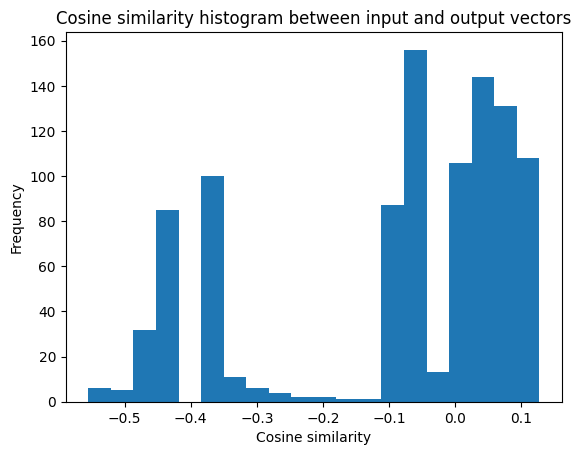

In [22]:
correlations = []
outputs = model_eigenvectors(residual_vectors)
for i in range(len(outputs)):
    intput_vector = residual_vectors[i].squeeze().view(1, -1)
    output_vector = outputs[i].squeeze().view(1, -1)
    correlation = torch.nn.functional.cosine_similarity(intput_vector, output_vector)
    correlations.append(correlation.cpu().detach().numpy()[0])


correlations
mean = np.mean(correlations)
median = np.median(correlations)
Q5 = np.percentile(correlations, 5)
Q1 = np.percentile(correlations, 25)
Q3 = np.percentile(correlations, 75)
Q95 = np.percentile(correlations, 95)
std = np.std(correlations)
print(f"Mean: {mean}, Std: {std}, Median: {median}, Q1: {Q1}, Q3: {Q3}, Q5: {Q5}, Q95: {Q95}")

# histogram of correlations
import matplotlib.pyplot as plt
plt.hist(correlations, bins=20)
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.title("Cosine similarity histogram between input and output vectors")
plt.show()

Mean: -0.36850231885910034, Std: 0.1994459480047226, Median: -0.3970625698566437, Q1: -0.4951299875974655, Q3: -0.34709203988313675, Q5: -0.5860474675893783, Q95: 0.15769173279404639


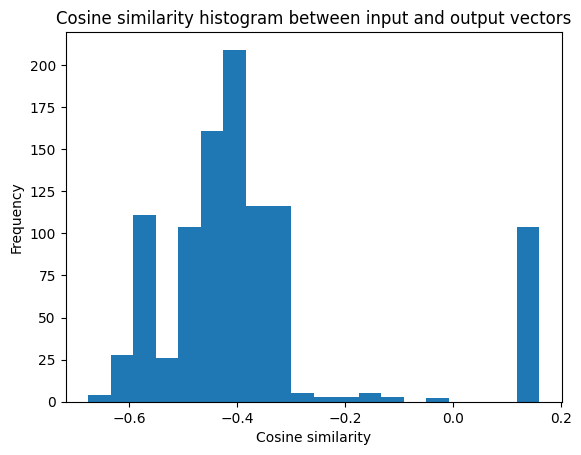

In [23]:
correlations = []
outputs = model_simulation(residual_vectors)
for i in range(len(outputs)):
    intput_vector = residual_vectors[i].squeeze().view(1, -1)
    output_vector = outputs[i].squeeze().view(1, -1)
    correlation = torch.nn.functional.cosine_similarity(intput_vector, output_vector)
    correlations.append(correlation.cpu().detach().numpy()[0])


correlations
mean = np.mean(correlations)
median = np.median(correlations)
Q5 = np.percentile(correlations, 5)
Q1 = np.percentile(correlations, 25)
Q3 = np.percentile(correlations, 75)
Q95 = np.percentile(correlations, 95)
std = np.std(correlations)
print(f"Mean: {mean}, Std: {std}, Median: {median}, Q1: {Q1}, Q3: {Q3}, Q5: {Q5}, Q95: {Q95}")

# histogram of correlations
import matplotlib.pyplot as plt
plt.hist(correlations, bins=20)
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.title("Cosine similarity histogram between input and output vectors")
plt.show()

Mean: -0.4899858832359314, Std: 0.06381328403949738, Median: -0.4769703149795532, Q1: -0.5661564022302628, Q3: -0.45306310057640076


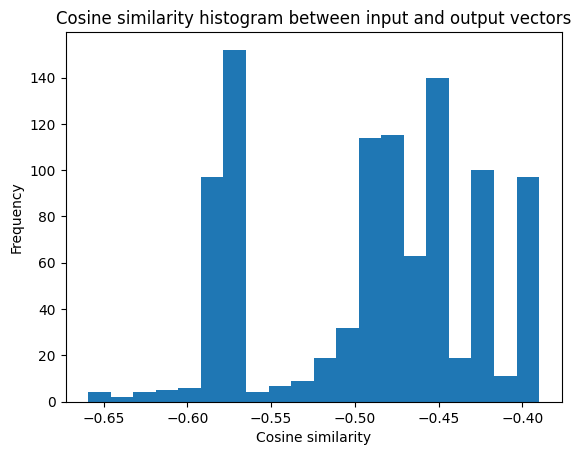

In [24]:
correlations = []
input_vectors = []
output_vectors = []

for i in range(len(residual_vectors)):
    input_vector = residual_vectors[i].reshape(1, -1).squeeze(0)
    output_vector = A_inverse @ input_vector.cpu().detach().numpy()
    input_vectors.append(input_vector.cpu().detach().numpy())
    output_vectors.append(output_vector)
    output_vector = torch.tensor(output_vector).float().to("cuda")
    correlation = torch.nn.functional.cosine_similarity(input_vector, output_vector, dim=0).cpu().detach().numpy()
    correlations.append(correlation)

correlations
mean = np.mean(correlations)
median = np.median(correlations)
Q1 = np.percentile(correlations, 25)
Q3 = np.percentile(correlations, 75)
std = np.std(correlations)
print(f"Mean: {mean}, Std: {std}, Median: {median}, Q1: {Q1}, Q3: {Q3}")

# histogram of correlations
import matplotlib.pyplot as plt
plt.hist(correlations, bins=20)
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.title("Cosine similarity histogram between input and output vectors")
plt.show()

In [ ]:
# correlation between 